## Calculation of Inital Movement Vectors 

In [1]:
import seaborn as sns 
import pandas as pd 
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import math

In [2]:
def cart2pol(x, y):
    r = []
    theta = []
    for i in range(len(x)): 
        r.append(np.sqrt((x[i])**2 + (y[i])**2))
        theta.append(np.arctan2(y[i], x[i]))
    return(r, theta)

In [3]:
movement_dfs = []
trial_dfs = []
n_backward_reaches = {}

num_participants = 20

# load in all participants movement and trial data
for i in range(num_participants):
     if i in [5, 11, 18]:
        continue 
     movement_df = pd.read_csv(f'../data/data_movements_{i}.csv')
     # count and filter out negative reaches
     backward_reaches = movement_df.loc[(movement_df.state == 'reach') & (movement_df.y < 0)].drop_duplicates('trial')
     n_backward_reaches[i] = len(backward_reaches)
     movement_df = movement_df.loc[~movement_df.trial.isin(backward_reaches.trial)].copy() # ~ means 'not'. It is removing all backward reaches.
     movement_df['participant'] = i
     movement_dfs.append(movement_df)
     trial_dfs.append(pd.read_csv(f'../data/data_trials_{i}.csv'))

for df in trial_dfs:
    df['trial'] = df.trial - 1

In [4]:
n_backward_reaches

{0: 4,
 1: 2,
 2: 9,
 3: 1,
 4: 2,
 6: 1,
 7: 3,
 8: 1,
 9: 6,
 10: 1,
 12: 4,
 13: 0,
 14: 0,
 15: 1,
 16: 3,
 17: 9,
 19: 0}

In [5]:
# remove backward reaches 
movement_dfs_no_back = []
for d in movement_dfs: 
    d = d.loc[(d.state == 'reach') & (d.y >= 0)].copy()
    movement_dfs_no_back.append(d)

### Interpolate Data

In [18]:
def interpolation(df): 

    t = df["time"]
    x = df["x"]
    y = df["y"]
    trial = df['trial']

    xs = CubicSpline(t, x)
    ys = CubicSpline(t, y)

    tt = np.linspace(t.min(), t.max(), 100)
    xx = xs(tt)
    yy = ys(tt)


    interpolated_df = pd.DataFrame({'time': tt, 'x': xx, 'y': yy})
 

    return interpolated_df

interpolated_dfs = []

for i, movement_df in enumerate(movement_dfs_no_back): 
    interpolated_df = movement_df.groupby('trial').apply(interpolation)
    interpolated_df['participant'] = i
    interpolated_dfs.append(interpolated_df)
    #fig, ax = plt.subplots(1, 2, squeeze=False)
    #ax[0, 0].plot(x, y, '.')
    #ax[0, 1].plot(xx, yy, '.')
    #plt.show()
    # fig, ax = plt.subplots(1, 2, squeeze=False)
    # sns.scatterplot(data=movement_df, x='x', y='y', ax=ax[0,0])
    # sns.scatterplot(data=interpolated_df, x='x', y='y', ax=ax[0,1])
    # plt.show()
    # fig, ax = plt.subplots(1, 2, squeeze=False)
    # ax[0, 0].plot(x, y, '.')
    # ax[0, 1].plot(xx, yy, '.')
    # plt.show()

In [19]:
# prep the previous uncertainty information in the first trial df as uncertainty is trial matched across participants.

previous_uncertainty = ['no_uncertainty'] * 21

for i in range(21, 300):
    prev_row = trial_dfs[0].iloc[i - 1]
    if prev_row.no_uncertainty == True:
        previous_uncertainty.append('no_uncertainty')
    elif prev_row.low_uncertainty == True: 
        previous_uncertainty.append('low_uncertainty')
    elif prev_row.high_uncertainty == True: 
        previous_uncertainty.append('high_uncertainty')
    elif prev_row.unlimited_uncertainty == True: 
        previous_uncertainty.append('unlimited_uncertainty')
    else: 
        previous_uncertainty.append('unlimited_uncertainty')
    

trial_dfs[0]['previous_uncertainty'] = previous_uncertainty

In [20]:
interpolated_dfs = pd.concat(interpolated_dfs)

micro_plot_df = pd.merge(interpolated_dfs, trial_dfs[0], on='trial', how='left').reset_index()


In [21]:
micro_plot_df

,index,trial,time,x,y,participant,Unnamed: 0,cursor_vis,midpoint_vis,endpoint_vis,...,cycle,target_angle,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty,endpoint_theta,movement_time,movement_initiation_time,previous_uncertainty
0,0,0,13.002435,-0.125304,0.354256,0,0,1.0,1.0,0.0,...,0,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty
1,1,0,13.003764,-0.125470,0.406345,0,0,1.0,1.0,0.0,...,0,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty
2,2,0,13.005093,-0.125479,0.458483,0,0,1.0,1.0,0.0,...,0,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty
3,3,0,13.006422,-0.125314,0.510768,0,0,1.0,1.0,0.0,...,0,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty
4,4,0,13.007751,-0.124958,0.563297,0,0,1.0,1.0,0.0,...,0,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505295,505295,299,2052.795434,0.545996,8.650978,16,0,0.0,0.0,0.0,...,299,90,0.0,0.0,0.0,0.0,81.894757,0.116772,0.317194,unlimited_uncertainty
505296,505296,299,2052.797288,0.557151,8.766507,16,0,0.0,0.0,0.0,...,299,90,0.0,0.0,0.0,0.0,81.894757,0.116772,0.317194,unlimited_uncertainty
505297,505297,299,2052.799142,0.568565,8.884302,16,0,0.0,0.0,0.0,...,299,90,0.0,0.0,0.0,0.0,81.894757,0.116772,0.317194,unlimited_uncertainty
505298,505298,299,2052.800996,0.580272,9.004755,16,0,0.0,0.0,0.0,...,299,90,0.0,0.0,0.0,0.0,81.894757,0.116772,0.317194,unlimited_uncertainty


<Figure size 640x480 with 0 Axes>

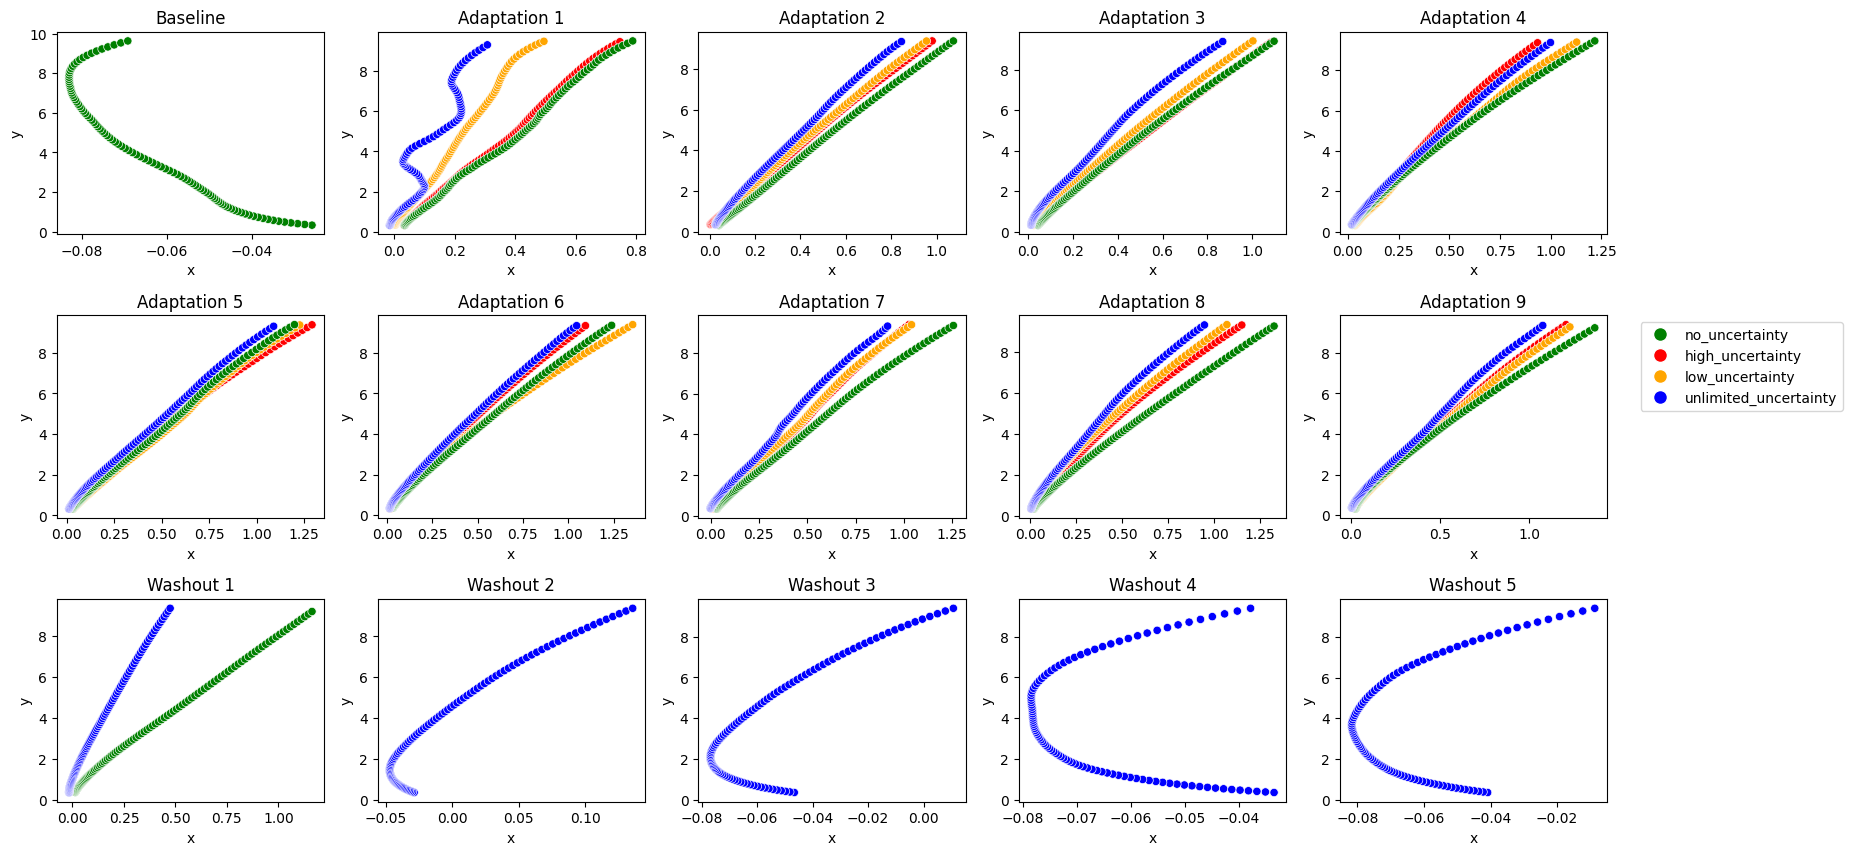

In [52]:
# reassign all trials into groups of 25
micro_plot_df['group'] = micro_plot_df.trial // 20
micro_plot_df['timestep'] = micro_plot_df[['participant', 'trial', 'time']].groupby(['participant', 'trial']).cumcount()

micro_plot_df = micro_plot_df

# get average reaches per group for every previous uncertainty condition. 
average_reaches = micro_plot_df.groupby(['group', 'previous_uncertainty', 'timestep']).agg({'x': 'mean', 'y': 'mean'}).reset_index()

average_reaches

# plot 
plt.clf()

# map colours to uncertainty conditions
cmap = {
    'no_uncertainty': 'green',
    'low_uncertainty': 'orange',
    'high_uncertainty': 'red',
    'unlimited_uncertainty': 'blue'
}
# list subplot names 
subplot_names = ['Baseline', 
                 'Adaptation 1', 'Adaptation 2', 'Adaptation 3', 'Adaptation 4', 'Adaptation 5', 'Adaptation 6', 'Adaptation 7', 'Adaptation 8', 'Adaptation 9',  
                 'Washout 1', 'Washout 2', 'Washout 3', 'Washout 4', 'Washout 5']

# Initialize lists to collect legend handles and labels
legend_handles = []
legend_labels = []

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
for i in range(15):
    data = average_reaches.loc[average_reaches.group == i].copy()
    subset_custom_palette = [cmap[category] for category in data['previous_uncertainty'].unique()]
    sns.scatterplot(data=average_reaches.loc[(average_reaches.group == i)], x='x', y='y', hue='previous_uncertainty', ax=axs[i//5, i%5], legend=False, palette=subset_custom_palette)
    axs[i//5, i%5].set_title(subplot_names[i])

    # Collect legend handles and labels for the current subset
    for category in data['previous_uncertainty'].unique():
        if category not in legend_labels:
            legend_labels.append(category)
            legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=cmap[category], markersize=10))

# Add the shared legend to one of the subplots
axs[1, 1].legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(4.7, 1))

plt.subplots_adjust(hspace=0.4)

plt.show()

In [10]:
micro_plot_df

,index,trial,time,x,y,Unnamed: 0,cursor_vis,midpoint_vis,endpoint_vis,cursor_sig,...,target_angle,no_uncertainty,low_uncertainty,high_uncertainty,unlimited_uncertainty,endpoint_theta,movement_time,movement_initiation_time,previous_uncertainty,group
0,0,0,13.002435,-0.125304,0.354256,0,1.0,1.0,0.0,0.0,...,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty,0
1,1,0,13.003764,-0.125470,0.406345,0,1.0,1.0,0.0,0.0,...,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty,0
2,2,0,13.005093,-0.125479,0.458483,0,1.0,1.0,0.0,0.0,...,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty,0
3,3,0,13.006422,-0.125314,0.510768,0,1.0,1.0,0.0,0.0,...,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty,0
4,4,0,13.007751,-0.124958,0.563297,0,1.0,1.0,0.0,0.0,...,90,0.0,0.0,0.0,0.0,85.529673,0.148947,0.435249,no_uncertainty,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505295,505295,299,2052.795434,0.545996,8.650978,0,0.0,0.0,0.0,0.0,...,90,0.0,0.0,0.0,0.0,81.894757,0.116772,0.317194,unlimited_uncertainty,11
505296,505296,299,2052.797288,0.557151,8.766507,0,0.0,0.0,0.0,0.0,...,90,0.0,0.0,0.0,0.0,81.894757,0.116772,0.317194,unlimited_uncertainty,11
505297,505297,299,2052.799142,0.568565,8.884302,0,0.0,0.0,0.0,0.0,...,90,0.0,0.0,0.0,0.0,81.894757,0.116772,0.317194,unlimited_uncertainty,11
505298,505298,299,2052.800996,0.580272,9.004755,0,0.0,0.0,0.0,0.0,...,90,0.0,0.0,0.0,0.0,81.894757,0.116772,0.317194,unlimited_uncertainty,11


In [ ]:
# def interpolate(df):
    
#     df = df[['x', 'y', 'time', 'trial', 'state', 'participant']]

#     # Desired timestamp granularity
#     timestamp_granularity = 0.001

#     # Create an empty list to store interpolated dataframes
#     interpolated_dfs = []

#     # Iterate through the rows of the original DataFrame
#     for i in range(len(df) - 1):
#         # Extract data from the current and next rows
#         current_row = df.iloc[i]
#         next_row = df.iloc[i + 1]

#         # Calculate the time points for interpolation
#         t1 = current_row["time"]
#         t2 = next_row["time"]

#         # Calculate the number of points to interpolate between t1 and t2
#         num_points = int((t2 - t1) / timestamp_granularity)

#         # Create an array of interpolated time points
#         interpolated_times = np.linspace(t1, t2, num_points + 1)

#         # Perform linear interpolation for 'x' and 'y' columns
#         interpolated_x = np.interp(interpolated_times, [t1, t2], [current_row["x"], next_row["x"]])
#         interpolated_y = np.interp(interpolated_times, [t1, t2], [current_row["y"], next_row["y"]])

#         # Create a new DataFrame for this segment of interpolation
#         interpolated_segment = pd.DataFrame({
#             "x": interpolated_x,
#             "y": interpolated_y,
#             "time": interpolated_times,
#             "trial": [current_row["trial"]] * (num_points + 1),  # Include trial number
#             "state": [current_row["state"]] * (num_points + 1),  # Include state
#             "participant": [current_row["participant"]] * (num_points + 1) # Include participand
#         })

#         # Append the interpolated segment to the list
#         interpolated_dfs.append(interpolated_segment)

#     # Concatenate all interpolated segments into one DataFrame
#     interpolated_df = pd.concat(interpolated_dfs, ignore_index=True)

#     return interpolated_df

# # interpolate all participants' movement data for a time granularity of 0.001s
# interpolated_dfs = [interpolate(df) for df in movement_dfs]

In [ ]:
# all_interpolated = pd.concat(interpolated_dfs)
# all_interpolated = all_interpolated.loc[(all_interpolated.state == 'reach')].copy()
# all_interpolated['timestep'] = all_interpolated.groupby(['participant', 'trial']).cumcount()

# weird_reaches = all_interpolated.groupby(['participant', 'trial']).agg({'timestep': 'max'}).reset_index()

# weird_reaches.loc[weird_reaches.participant == 0].boxplot('timestep', showmeans=True, meanline=True)

# part0_weird = weird_reaches.loc[(weird_reaches.participant == 0) & (weird_reaches.timestep > 300)]

In [ ]:
# plt.clf()
# sns.scatterplot(data=micro_plot_df.loc[(micro_plot_df.participant == 0) & (micro_plot_df.trial.isin(part0_weird.trial))], x = 'x', y = 'y', hue = 'previous_uncertainty')
# plt.show()

In [ ]:
average_reaches.loc[average_reaches.group == 8].previous_uncertainty.unique()

In [ ]:
plt.clf()
sns.scatterplot(data=average_reaches.loc[(average_reaches.group == 11)], x='x', y='y', hue='previous_uncertainty')
plt.show()

In [ ]:
# plot 
plt.clf()
sns.scatterplot(data=micro_plot_df.loc[(micro_plot_df.trial == 117) & (micro_plot_df.participant == 3)], x='x', y='y', hue='previous_uncertainty', color='Set2')
plt.show()

### Calculate initial movmement vector and midpoint theta
Initial movement vector (IMV) is calculated by finding the point of peak velocity. The angular difference between the optimal movement vector and first point at which velocity exceeds 5% of peak velocity after a 2cm reach is considered the inital movement vector. 

Midpoint theta is defined and calculated as the first measured angle at 5cm (or higher until first measure is found). 

In [ ]:
# velocity is the change in distance over the change in time

def get_change_dist(df):
    x1 = df['x'].values[:-1]
    x2 = df['x'].values[1:]
    y1 = df['y'].values[:-1]
    y2 = df['y'].values[1:]

    dist = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    # insert adds a 0 at the start because change in dist at the start is 0
    return np.insert(dist, 0, 0) 

# add all change in dist into all the interpolated dfs and then calculate velocity for each
for df in interpolated_dfs:
    df['change_in_dist'] = get_change_dist(df)
    # velocity is the change in distance over the change in time
    df['velocity'] = df.change_in_dist / 0.001

In [ ]:
# calculate onset velocities and join back to interpolated data
def get_onset(df): 
    onset_df = df.loc[df.state == 'reach'].groupby('trial').agg({'velocity': 'max'}).reset_index()
    onset_df = onset_df.rename(columns={'velocity': 'max_vel'})
    onset_df['onset_vel'] = onset_df.max_vel * 0.05 
    joined = pd.merge(df, onset_df, on='trial', how='left')
    return joined

interpolated_w_onset_dfs = [get_onset(df) for df in interpolated_dfs]

In [ ]:
# plot velocity over time 
tmp = interpolated_w_onset_dfs[0].loc[interpolated_w_onset_dfs[0].trial == 150].copy()
tmp.plot(x='time', y='velocity')
plt.axhline(y=tmp.iloc[0].onset_vel, color='r', linestyle='--')

In [ ]:
# initial movement vector is the angular difference between optimal vector (90deg) and the movement vector at movement onset (velocity exceeds 5% of peak)
def get_imv(df, thresh=2.0):
    imv_df = df.copy()
    r, theta = cart2pol(imv_df.x.values, imv_df.y.values)
    imv_df['r'] = r
    imv_df['theta'] = theta
    imv_df['theta'] = imv_df.theta.apply(math.degrees)
    imv_df = imv_df.loc[(imv_df.velocity > imv_df.onset_vel) & (imv_df.r >= thresh) & (imv_df.state == 'reach')].drop_duplicates('trial')
    imv_df['theta'] = abs(90 - imv_df.theta)
    return imv_df

# since optimal vector is at 90 degrees, angular difference is 90 - theta

imv_dfs = [get_imv(df) for df in interpolated_w_onset_dfs]
# calculate midpoint theta
mid_dfs = [get_imv(df, thresh=5.0) for df in interpolated_w_onset_dfs]

In [ ]:
trial_df = pd.concat(trial_dfs, ignore_index=True).drop_duplicates('trial')

In [ ]:
def add_prev_uncertainty(imv_df, trial):
    previous_uncertainty = ['no_uncertainty'] * 21

    for i in range(21, len(trial) - 99):
        prev_row = trial.iloc[i - 1]
        if prev_row.no_uncertainty == True:
            previous_uncertainty.append('no_uncertainty')
        elif prev_row.low_uncertainty == True: 
            previous_uncertainty.append('low_uncertainty')
        elif prev_row.high_uncertainty == True: 
            previous_uncertainty.append('high_uncertainty')
        elif prev_row.unlimited_uncertainty == True: 
            previous_uncertainty.append('unlimited_uncertainty')
        else: 
            previous_uncertainty.append('unlimited_uncertainty')

    imv_df_w_prev_uncertainty = pd.merge(imv_df, trial, on = 'trial', how = 'left')

    previous_uncertainty += ['unlimited_uncertainty'] * (300 - len(previous_uncertainty))
    imv_df_w_prev_uncertainty['previous_uncertainty'] = previous_uncertainty

    return imv_df_w_prev_uncertainty

imv_dfs_w_prev_uncertainty = []
for i in range(len(imv_dfs)):
    imv_dfs_w_prev_uncertainty.append(add_prev_uncertainty(imv_dfs[i], trial_dfs[i]))

In [ ]:
# remove any backwards reaching trials

dfs_remove_backwards_reaches = []

for i in range(len(movement_dfs)):
    imv_df = imv_dfs_w_prev_uncertainty[i]
    movement_df = movement_dfs[i]
    backward_reaches = movement_df.loc[(movement_df.state == 'reach') & (movement_df.y < 0)].drop_duplicates('trial')
    dfs_remove_backwards_reaches.append(imv_df.loc[~imv_df.trial.isin(backward_reaches.trial)].copy())

In [ ]:
combined_df = pd.concat(dfs_remove_backwards_reaches)[['trial', 'theta', 'r', 'previous_uncertainty']]
combined_df = pd.merge(
    combined_df.rename(columns={'theta': 'initial_theta'}),
    pd.concat(mid_dfs).rename(columns={'theta': 'midpoint_theta'})[['trial', 'midpoint_theta']],
    on='trial',
    how='left')

combined_df = combined_df.groupby('trial').agg({'initial_theta': 'mean', 'midpoint_theta': 'mean', 'previous_uncertainty': 'first'}).reset_index()

combined_df = pd.merge(combined_df, trial_df, on='trial', how='left')

In [ ]:
combined_df

In [ ]:
combined_df['midpoint_error'] = combined_df.midpoint_theta + combined_df.rot
regression_df = combined_df[['trial', 'initial_theta', 'previous_uncertainty', 'midpoint_error']].copy()

In [ ]:
sns.scatterplot(data=combined_df, x='trial', y='initial_theta', hue='previous_uncertainty')

### Extract important data for regression analysis 

In [ ]:
# save to csv
regression_df.to_csv('../data/regression_data.csv', index=False)

### Endpoint theta plot

In [ ]:
# remove any backwards reaching trials

trial_dfs_no_back_reach = []

for i in range(len(movement_dfs)):
    trial_df = trial_dfs[i]
    movement_df = movement_dfs[i]
    backward_reaches = movement_df.loc[(movement_df.state == 'reach') & (movement_df.y < 0)].drop_duplicates('trial')
    trial_dfs_no_back_reach.append(trial_df.loc[~trial_df.trial.isin(backward_reaches.trial)].copy())

In [ ]:
# endpoint theta as recorded during the experiment 

endpoint_theta_df = pd.concat(trial_dfs_no_back_reach)[['trial', 'no_uncertainty', 'low_uncertainty', 'high_uncertainty', 'unlimited_uncertainty', 'endpoint_theta']]
endpoint_theta_mean= endpoint_theta_df[['trial', 'endpoint_theta']].groupby('trial').agg('mean').reset_index()
endpoint_theta = pd.merge(endpoint_theta_mean, endpoint_theta_df.drop_duplicates('trial').drop('endpoint_theta', axis=1), on='trial', how='left')
endpoint_theta

In [ ]:
previous_uncertainty = ['no_uncertainty'] * 21

for i in range(21, 300):
    prev_row = endpoint_theta.iloc[i - 1]
    if prev_row.no_uncertainty == True:
        previous_uncertainty.append('no_uncertainty')
    elif prev_row.low_uncertainty == True: 
        previous_uncertainty.append('low_uncertainty')
    elif prev_row.high_uncertainty == True: 
        previous_uncertainty.append('high_uncertainty')
    elif prev_row.unlimited_uncertainty == True: 
        previous_uncertainty.append('unlimited_uncertainty')
    else: 
        previous_uncertainty.append('unlimited_uncertainty')
    

endpoint_theta['previous_uncertainty'] = previous_uncertainty

In [ ]:
endpoint_theta

In [ ]:
# subtract theta from ideal angle reach of 90 degrees 
endpoint_theta['endpoint_theta'] = abs(90 - endpoint_theta.endpoint_theta)
endpoint_theta

In [ ]:
sns.scatterplot(data=endpoint_theta, x='trial', y='endpoint_theta', hue='previous_uncertainty')

In [ ]:
endpoint_theta.to_csv('../data/endpoint_theta.csv')

In [ ]:
# def get_emv(df):
#     emv_df = df.copy()
#     r, theta = cart2pol(emv_df.x.values, emv_df.y.values)
#     emv_df['r'] = r
#     emv_df['theta'] = theta
#     emv_df['theta'] = emv_df.theta.apply(math.degrees)
#     emv_df = emv_df.loc[(emv_df.r >= 10.0) & (emv_df.state == 'reach')].drop_duplicates('trial')
#     emv_df['theta'] = abs(90 - emv_df.theta)
#     return emv_df

# emv_dfs = [get_emv(df) for df in interpolated_w_onset_dfs]


In [ ]:
# emv_dfs = pd.concat(emv_dfs)

In [ ]:
# emv_dfs = emv_dfs[['trial','theta']].groupby('trial').agg({'theta': 'mean'})

In [ ]:
# sns.scatterplot(data=emv_dfs, x='trial', y='theta')